In [1]:
import scipy as sp
import numpy as np
import cvxpy as cp

# 0. Fast solve QP

In [2]:
n = int(1e6)
p = 50
m = 50

rng = np.random.default_rng(0)

In [3]:
xk = rng.normal(0, 1, (n, 1))
x_feas = rng.normal(0, 1, (n, 1))
A = rng.normal(0, 1, (p, n))
b = A @ x_feas
F = rng.normal(0, 1, (m+1, n))
g = F @ x_feas

In [4]:
x = cp.Variable((n,1))
constrs = [F @ x <= g, A @ x == b]
prob = cp.Problem(cp.Minimize(cp.sum_squares(x-xk)), constrs)
prob.solve(verbose=True)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Oct 09 12:28:05 PM: Your problem has 1000000 variables, 2 constraints, and 0 parameters.
(CVXPY) Oct 09 12:28:05 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 09 12:28:05 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 09 12:28:05 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 09 12:28:05 PM: Compiling problem (target solver=OSQP).
(CVXPY) Oct 09 12:28:05 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStu

153.35218352978677

In [5]:
%%timeit
Fxk = F @ xk
Axk = A @ xk
FF = F @ F.T
FA = F @ A.T
AA = A @ A.T
Mat = np.block([[FF, FA], [FA.T, AA]])

321 ms ± 12.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
Fxk = F @ xk
Axk = A @ xk
FF = F @ F.T
FA = F @ A.T
AA = A @ A.T
Mat = np.block([[FF, FA], [FA.T, AA]])

In [7]:
lamb = cp.Variable((m+1,1))
nu = cp.Variable((p,1))
constrs = [Fxk - FF @ lamb - FA @ nu <= g, Axk - FA.T @ lamb - AA @ nu == b]
prob = cp.Problem(cp.Minimize(cp.quad_form(cp.vstack([lamb, nu]), Mat)), constrs)
prob.solve(verbose=True)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Oct 09 12:40:30 PM: Your problem has 101 variables, 2 constraints, and 0 parameters.
(CVXPY) Oct 09 12:40:30 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 09 12:40:30 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 09 12:40:30 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 09 12:40:30 PM: Compiling problem (target solver=OSQP).
(CVXPY) Oct 09 12:40:30 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffin

153.35218352978634

# 1. Primal-dual SOCP

## Setup

In [8]:
n = 500
p = 200
l = 10

rng = np.random.default_rng(1)

In [9]:
def proj_K(u_orig):
    u = np.copy(u_orig)
    for i in range(l):
        norm = np.linalg.norm(u[i*(n//l):(i+1)*(n//l)-1])
        t = u[(i+1)*(n//l)-1,0]
        
        if norm < -t:
            u[i*(n//l):(i+1)*(n//l)] = 0.
        
        elif norm > np.abs(t):
            u[(i+1)*(n//l)-1] = norm
            u[i*(n//l):(i+1)*(n//l)] *= 0.5 * (1 + t/norm)

    return u

In [10]:
z = rng.normal(0, 1, (n, 1))
u_feas = proj_K(z)
s_feas = u_feas - z
for i in range(l):
    thresh = np.linalg.norm(u_feas[i*(n//l):(i+1)*(n//l)-1])
    if u_feas[(i+1)*(n//l)-1] < thresh:
        u_feas[(i+1)*(n//l)-1] = thresh

    thresh = np.linalg.norm(s_feas[i*(n//l):(i+1)*(n//l)-1])
    if s_feas[(i+1)*(n//l)-1] < thresh:
        s_feas[(i+1)*(n//l)-1] = thresh

v_feas = rng.normal(0, 1, (p, 1))
A = rng.normal(0, 1, (p, n))
b = A @ u_feas
c = s_feas + A.T @ v_feas

In [11]:
Q = sp.sparse.bmat([[None, -A.T, c],
                   [A, None, -b],
                   [-c.T, b.T, None]])

In [12]:
def viol(u, s):
    return np.maximum(np.linalg.norm(u - proj_K(u)), np.linalg.norm(u - proj_K(u)))

### Verifying feasibility

In [13]:
u = cp.Variable((n,1))
v = cp.Variable((p,1))
s = cp.Variable((n,1))

In [14]:
obj = cp.Minimize(c.T @ u)
constrs = [A @ u == b,
          *[cp.norm(u[i*(n//l):(i+1)*(n//l)-1]) <= u[(i+1)*(n//l)-1] for i in range(l)]]

prob = cp.Problem(obj, constrs)
prob.solve()

119.16229930483351

In [15]:
obj = cp.Maximize(b.T @ v)
constrs = [c - A.T @ v == s,
          *[cp.norm(s[i*(n//l):(i+1)*(n//l)-1]) <= s[(i+1)*(n//l)-1] for i in range(l)]]

prob = cp.Problem(obj, constrs)
prob.solve()

119.1622992872

## PMM

In [16]:
def pmm_test_socp(M, max_iters):
    print("SOCP test. Memory: {}".format(M-1))
    solve_time = [0.]
    
    M_u = cp.Parameter((M,n))
    M_s = cp.Parameter((M,n))
    m_u = cp.Parameter((M,1))
    m_s = cp.Parameter((M,1))
    M_u.value = np.zeros((M,n))
    M_s.value = np.zeros((M,n))
    m_u.value = np.zeros((M,1))
    m_s.value = np.zeros((M,1))
    
    uk = cp.Parameter((n,1))
    vk = cp.Parameter((p,1))
    sk = cp.Parameter((n,1))
    uk.value = np.zeros((n,1))
    vk.value = np.zeros((p,1))
    sk.value = np.zeros((n,1))

    rhs = cp.vstack([u,v,np.ones((1,1))])
    lhs = cp.vstack([s,np.zeros((p+1,1))])

    Puk = proj_K(uk.value)
    if np.isclose(np.linalg.norm(uk.value - Puk), 0.):
        M_u.value[[0]] = 0.
        m_u.value[[0]] = 0.
    else:
        M_u.value[[0]] = (uk.value - Puk).T / np.linalg.norm(uk.value - Puk)
        m_u.value[[0]] = np.linalg.norm(uk.value - Puk) - M_u.value[[0]] @ uk.value

    Psk = proj_K(sk.value)
    if np.isclose(np.linalg.norm(sk.value - Psk), 0.):
        M_s.value[[0]] = 0.
        m_s.value[[0]] = 0.
    else:
        M_s.value[[0]] = (sk.value - Psk).T / np.linalg.norm(sk.value - Psk)
        m_s.value[[0]] = np.linalg.norm(sk.value - Psk) - M_s.value[[0]] @ sk.value
        
    obj = cp.Minimize(cp.sum_squares(u-uk) + cp.sum_squares(v-vk) + cp.sum_squares(s-sk))
    constrs = [m_u + M_u @ u <= 0., m_s + M_s @ s <= 0., lhs == Q @ rhs]
    prob = cp.Problem(obj, constrs)

    viols_socp = [viol(uk.value, sk.value)]

    for k in range(max_iters):
        prob.solve(solver="CLARABEL")
        solve_time.append(solve_time[-1] + prob.solver_stats.solve_time)

        uk.value = u.value
        vk.value = v.value
        sk.value = s.value

        Puk = proj_K(uk.value)
        if np.isclose(np.linalg.norm(uk.value - Puk), 0.):
            M_u.value[[(k+1) % M]] = 0.
            m_u.value[[(k+1) % M]] = 0.
        else:
            M_u.value[[(k+1) % M]] = (uk.value - Puk).T / np.linalg.norm(uk.value - Puk)
            m_u.value[[(k+1) % M]] = np.linalg.norm(uk.value - Puk) - M_u.value[[(k+1) % M]] @ uk.value
    
        Psk = proj_K(sk.value)
        if np.isclose(np.linalg.norm(sk.value - Psk), 0.):
            M_s.value[[(k+1) % M]] = 0.
            m_s.value[[(k+1) % M]] = 0.
        else:
            M_s.value[[(k+1) % M]] = (sk.value - Psk).T / np.linalg.norm(sk.value - Psk)
            m_s.value[[(k+1) % M]] = np.linalg.norm(sk.value - Psk) - M_s.value[[(k+1) % M]] @ sk.value
        
        viols_socp.append(viol(uk.value, sk.value))

    return viols_socp, solve_time

In [17]:
Ms = [0,5,20,100]
max_iters = 100
socp_dict = {}
socp_time = {}

for M in Ms:
    socp_dict[M], socp_time[M] = pmm_test_socp(M + 1, max_iters)

SOCP test. Memory: 0
SOCP test. Memory: 5
SOCP test. Memory: 20


/home/ndev/Documents/reserach/prox_minorant/.venv/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:222: UserWarning: Your problem has too many parameters for efficient DPP compilation. We suggest setting 'ignore_dpp = True'.
  warnings.warn(


SOCP test. Memory: 100


# 2. LMI

## Setup

In [18]:
q = 20
k = 10

rng = np.random.default_rng(1)

In [19]:
B = [rng.normal(0, 1, (q, q)) for i in range(k)]
C = [rng.normal(0, 1, (q, q)) for i in range(k)]
F = rng.normal(0, 1, (q, q))

A = [np.linalg.inv(F) @ (-(B[i] @ B[i].T) + C[i] - C[i].T) @ F for i in range(k)]

In [20]:
def viol(X):
    return max(
        np.maximum(np.linalg.eigvalsh(np.eye(q) - X)[-1], 0), 
        *[np.maximum(np.linalg.eigvalsh(X @ A[i] + A[i].T @ X)[-1], 0) for i in range(k)]
    )

### Verifying feasibility

In [21]:
X = cp.Variable((q,q), PSD=True)
constrs = [
    np.eye(q) << X,
    *[X @ A[i] + A[i].T @ X << 0 for i in range(k)]
]
prob = cp.Problem(cp.Minimize(0), constrs)
prob.solve()

0.0

## PMM

In [22]:
def pmm_test_sdp(M, max_iters):
    print("SDP test. Memory: {}".format(M-1))
    solve_time = [0.]
    
    X = cp.Variable((q,q), symmetric=True)
    Xj = cp.Parameter((q,q))
    U = [cp.Parameter((q,2)) for _ in range(M)]
    V = [cp.Parameter((q,2)) for _ in range(k*M)]
    
    C = np.array([[1., 0., 0., -1.],[0., 1., 1., 0.]])
    c = np.array([[-1.], [0.], [0.], [-1.]])
    
    xu = [cp.vec(U[i].T @ (np.eye(q) - X) @ U[i]) for i in range(M)]
    xv = [cp.vec(V[i].T @ (X @ A[i % k] + A[i % k].T @ X) @ V[i]) for i in range(k*M)]
    
    obj = cp.Minimize(cp.norm(X-Xj, "fro"))
    constrs = [
        *[cp.norm(C @ xu[i]) <= c.T @ xu[i] for i in range(M)],
        *[cp.norm(C @ xv[i]) <= c.T @ xv[i] for i in range(k*M)]
    ]
    prob = cp.Problem(obj, constrs)

    Xj.value = np.eye(q)
    
    for i in range(M):
        U[i].value = np.zeros((q,2))
    
    for i in range(k*M):
        V[i].value = np.zeros((q,2))
    
    viols_sdp = [viol(Xj.value)]

    for j in range(max_iters):
        U[j % M].value = np.linalg.eigh(np.eye(q) - Xj.value)[1][:,-2:]
        for i in range(k):
            V[i + k * (j % M)].value = np.linalg.eigh(Xj.value @ A[i] + A[i].T @ Xj.value)[1][:,-2:]
        
        prob.solve(solver="CLARABEL")
        solve_time.append(solve_time[-1] + prob.solver_stats.solve_time)
        
        Xj.value = X.value
        viols_sdp.append(viol(Xj.value))

    return viols_sdp, solve_time

In [23]:
Ms = [0,5,20,100]
max_iters = 100
sdp_dict = {}
sdp_time = {}

for M in Ms:
    sdp_dict[M], sdp_time[M] = pmm_test_sdp(M + 1, max_iters)

SDP test. Memory: 0


/home/ndev/Documents/reserach/prox_minorant/.venv/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


SDP test. Memory: 5
SDP test. Memory: 20
SDP test. Memory: 100


# Plotting

In [24]:
import matplotlib.pyplot as plt

In [25]:
plt.rcdefaults()

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 14,
    })

line_dict = {Ms[0]:"solid", Ms[1]:"dotted", Ms[2]:"dashed", Ms[3]:"dashdot"}

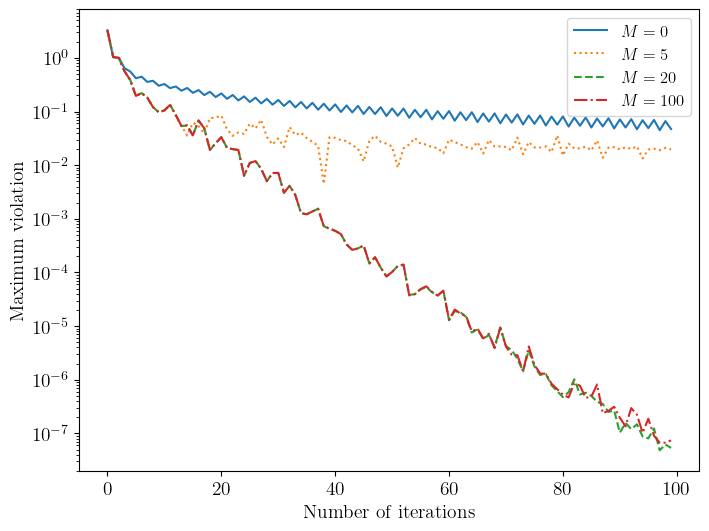

In [26]:
plt.figure(figsize=[8, 6])
for M in Ms:
    plt.semilogy(socp_dict[M][1:], linestyle=line_dict[M], label="$M={}$".format(M))

plt.legend(fontsize=12)
plt.xlabel('Number of iterations', fontsize=14)
plt.ylabel('Maximum violation', fontsize=14)

plt.savefig('./socp_exp.pdf', format='pdf')
plt.show()

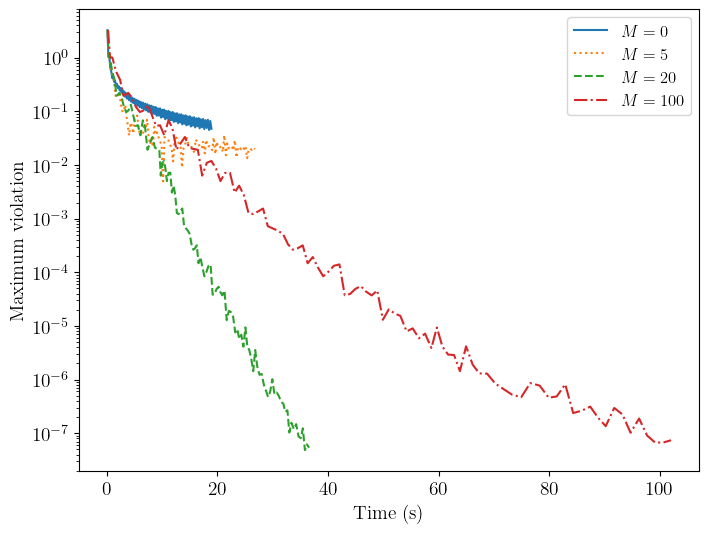

In [27]:
plt.figure(figsize=[8, 6])
for M in Ms:
    plt.semilogy(socp_time[M][1:], socp_dict[M][1:], linestyle=line_dict[M], label="$M={}$".format(M))

plt.legend(fontsize=12)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Maximum violation', fontsize=14)

plt.savefig('./socp_time.pdf', format='pdf')
plt.show()

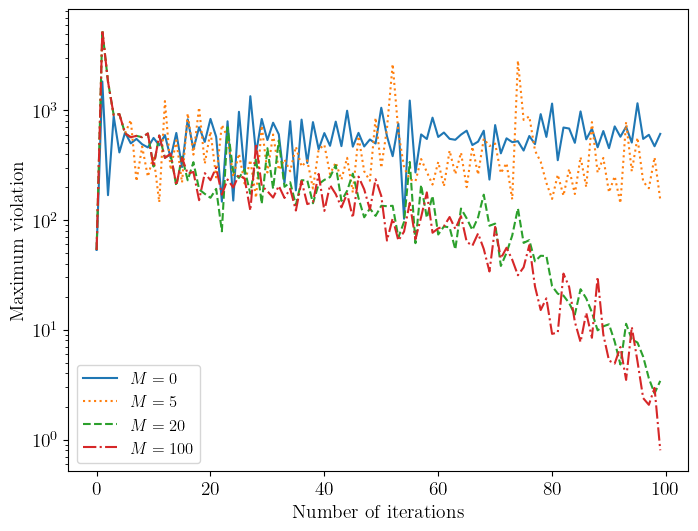

In [28]:
plt.figure(figsize=[8, 6])
for M in Ms:
    plt.semilogy(sdp_dict[M][1:], linestyle=line_dict[M], label="$M={}$".format(M))

plt.legend(fontsize=12)
plt.xlabel('Number of iterations', fontsize=14)
plt.ylabel('Maximum violation', fontsize=14)

plt.savefig('./sdp_exp.pdf', format='pdf')
plt.show()

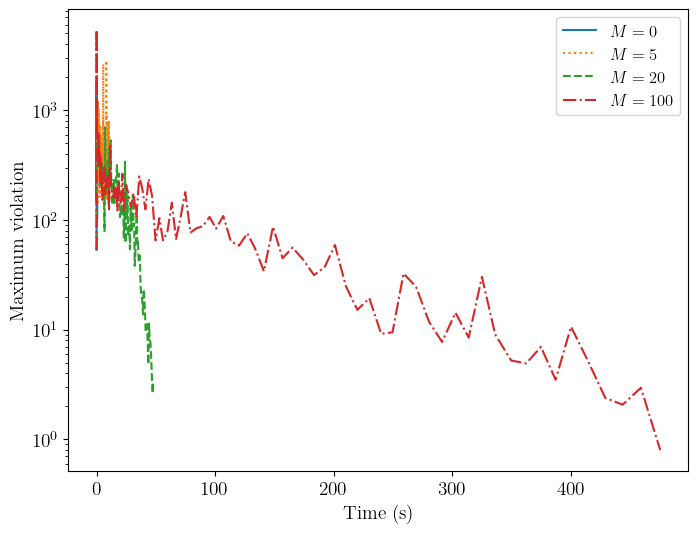

In [29]:
plt.figure(figsize=[8, 6])
for M in Ms:
    plt.semilogy(sdp_time[M][1:], sdp_dict[M][1:], linestyle=line_dict[M], label="$M={}$".format(M))

plt.legend(fontsize=12)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Maximum violation', fontsize=14)

plt.savefig('./sdp_time.pdf', format='pdf')
plt.show()